In [1]:
import os

import numpy as np
import pandas as pd

from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline


In [2]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('../data/sample_event', event_prefix))

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event_prefix, mem_bytes / 2**20))

event000001000 memory usage 18.46 MB


**Hits**

In [3]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


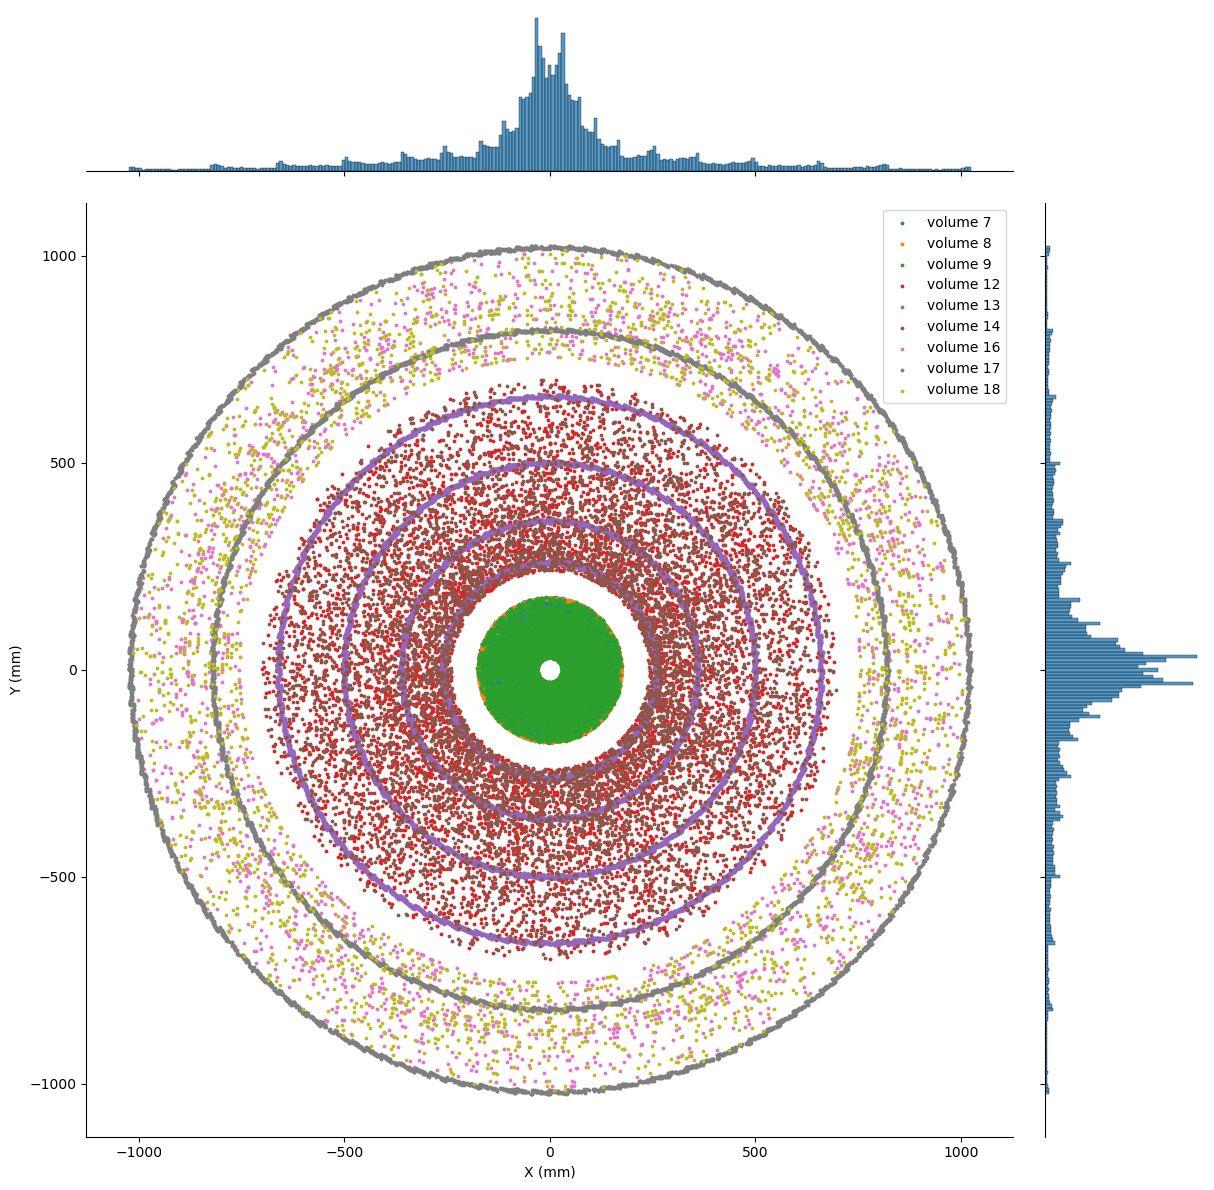

In [13]:
g = sns.jointplot(x=hits.x, y=hits.y, data=hits, s=1, height=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.savefig('../results/xy_intersection.png')
plt.show()

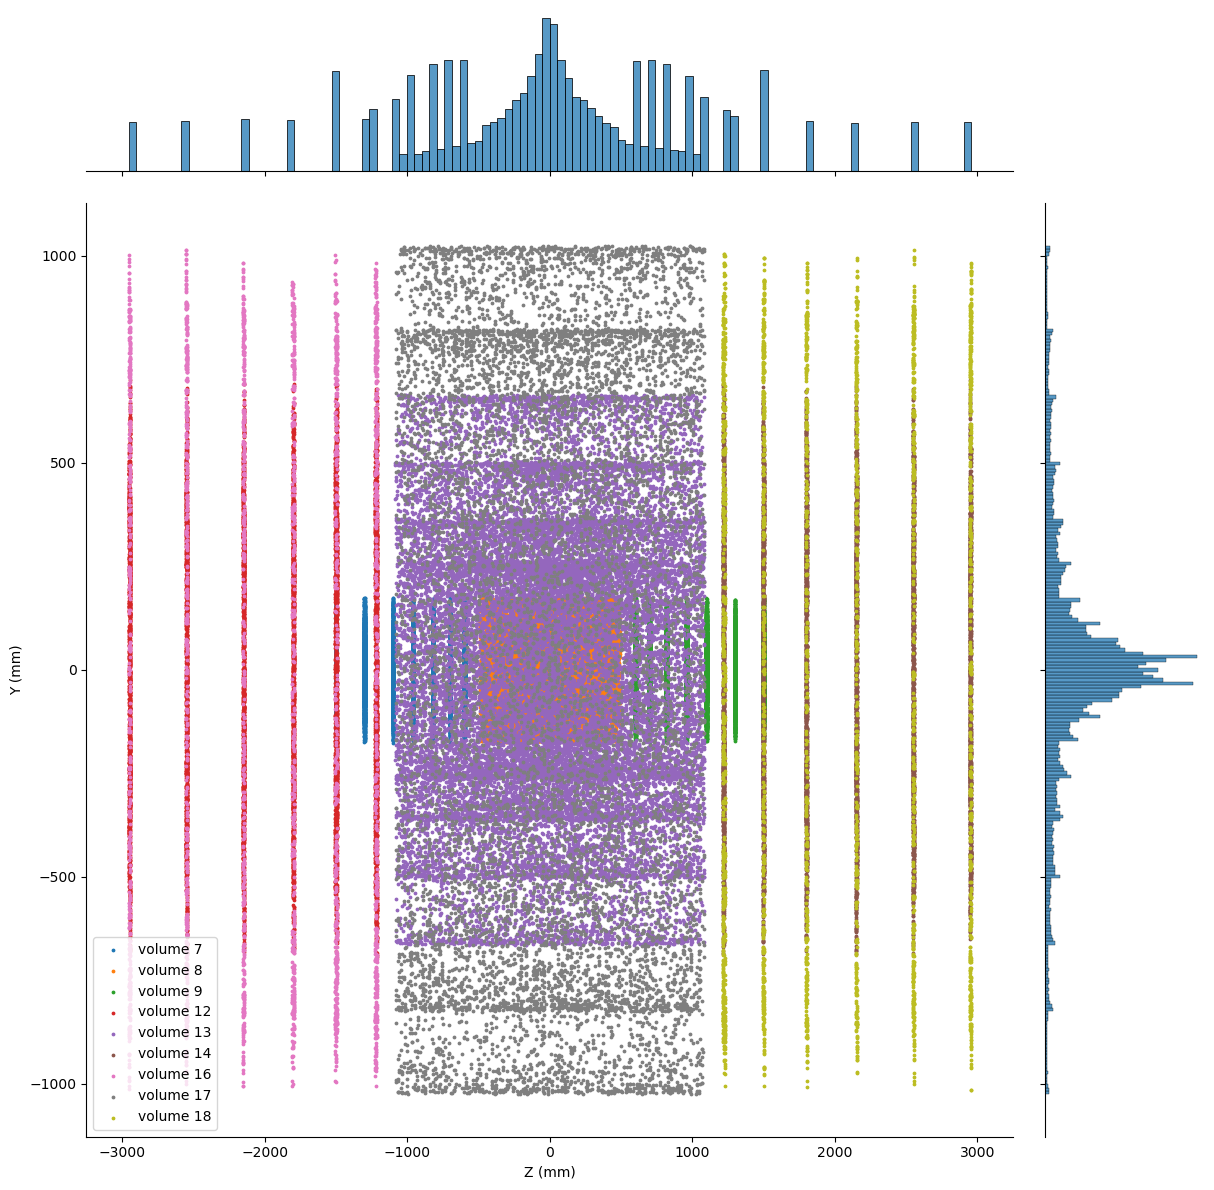

In [14]:
g = sns.jointplot(x=hits.z, y=hits.y, s=1, height=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.z, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.savefig('../results/yz_intersection.png')
plt.show()

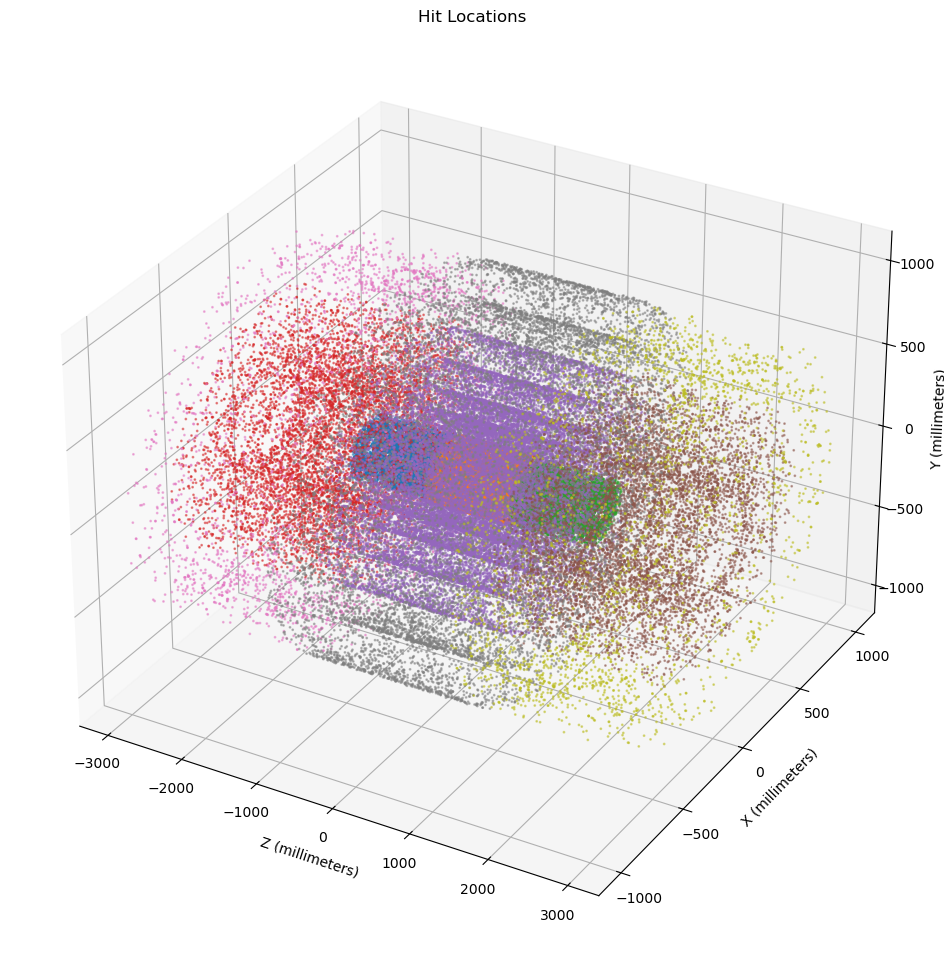

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for volume in volumes:
    v = hits[hits.volume_id == volume]
    ax.scatter(v.z, v.x, v.y, s=1, label='volume {}'.format(volume), alpha=0.5)
ax.set_title('Hit Locations')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
plt.savefig('../results/3d_visual_hits.png')
plt.show()

**Particles**

In [17]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


/var/folders/n2/td6lyvzx2pd6703265_bhdl80000gn/T/ipykernel_10127/369303765.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(particles.nhits.values, axlabel='Hits/Particle', bins=50)


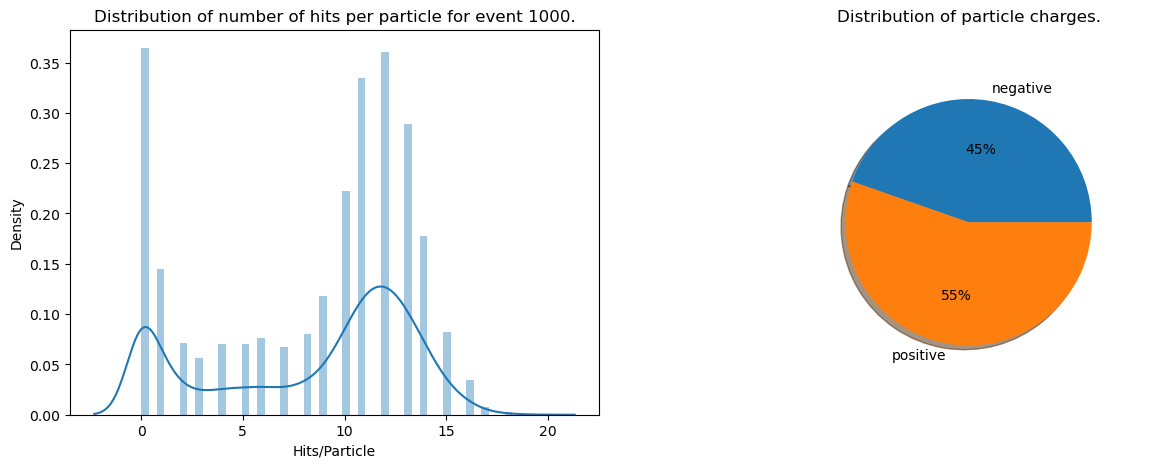

In [18]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(particles.nhits.values, axlabel='Hits/Particle', bins=50)
plt.title('Distribution of number of hits per particle for event 1000.')
plt.subplot(1, 2, 2)
plt.pie(particles.groupby('q')['vx'].count(),
        labels=['negative', 'positive'],
        autopct='%.0f%%',
        shadow=True,
        radius=0.8)
plt.title('Distribution of particle charges.')
plt.show()

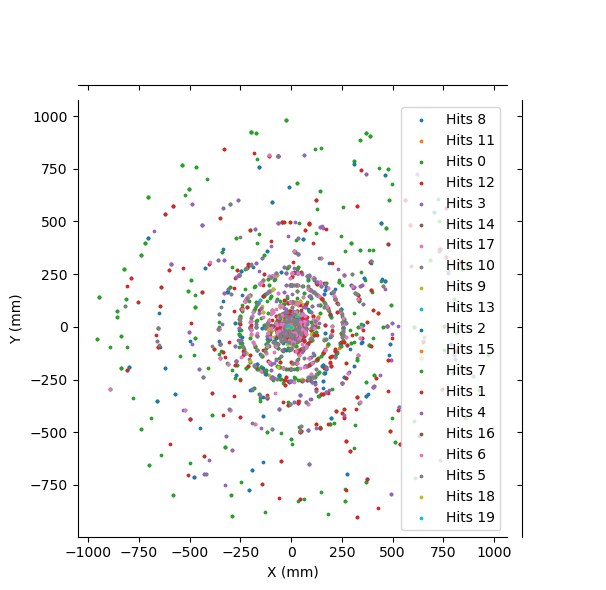

In [20]:
g = sns.jointplot(x = particles.vx, y = particles.vy,  s=3, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

n_hits = particles.nhits.unique()
for n_hit in n_hits:
    p = particles[particles.nhits == n_hit]
    plt.scatter(p.vx, p.vy, s=3, label='Hits {}'.format(n_hit))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.savefig('../results/xy_hits_intersection.png')
plt.show()

In [ ]:
g = sns.jointplot(x = particles.vz, y = particles.vy,  s=3, size=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

n_hits = particles.nhits.unique()
for n_hit in n_hits:
    p = particles[particles.nhits == n_hit]
    plt.scatter(p.vz, p.vy, s=3, label='Hits {}'.format(n_hit))

plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.savefig('../results/yz_hits_intersection.png')
plt.show()

In [ ]:
# Get particle id with max number of hits in this event
particle = particles.loc[particles.nhits == particles.nhits.max()].iloc[0]
particle2 = particles.loc[particles.nhits == particles.nhits.max()].iloc[1]

# Get points where the same particle intersected subsequent layers of the observation material
p_traj_surface = truth[truth.particle_id == particle.particle_id][['tx', 'ty', 'tz']]
p_traj_surface2 = truth[truth.particle_id == particle2.particle_id][['tx', 'ty', 'tz']]

p_traj = (p_traj_surface
          .append({'tx': particle.vx, 'ty': particle.vy, 'tz': particle.vz}, ignore_index=True)
          .sort_values(by='tz'))
p_traj2 = (p_traj_surface2
          .append({'tx': particle2.vx, 'ty': particle2.vy, 'tz': particle2.vz}, ignore_index=True)
          .sort_values(by='tz'))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(
    xs=p_traj.tx,
    ys=p_traj.ty,
    zs=p_traj.tz, marker='o')
ax.plot(
    xs=p_traj2.tx,
    ys=p_traj2.ty,
    zs=p_traj2.tz, marker='o')

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z  (mm) -- Detection layers')
plt.title('Trajectories of two particles as they cross the detection surface ($Z$ axis).')
plt.show()